# Global Parameters and Setup


### General library imports

In [3]:
from __future__ import annotations
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology, util
from skimage import color
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.measure import  regionprops, regionprops_table
from pathlib import Path
from fastprogress.fastprogress import progress_bar,master_bar
from enum import Enum
import tifffile
import pandas as pd
import cv2
import ntpath
import os
import time
import pickle
import re
import copy
import scipy
import builtins
import shutil
import contextlib
import zipfile
from itertools import starmap
from functools import partial
import random
import csv
from scipy import ndimage
from scipy.stats import skew
import numpy as np
from ipywidgets import interact, widgets, Layout
from IPython.utils.io import capture_output
import matplotlib.pyplot as plt
from typing import Dict, DefaultDict, Tuple, List, Union

import itertools
import math

import mediapy as media

#Get from Drive the folder libraries
from libraries.filter_cells_fns import remove_multiple_nuclei_cells, remove_large_objects, remove_touching_edge
from libraries.centers import get_centers, fill_label_holes, normalize
from libraries.qc_functions import apply_qc
from libraries.centroidtracker import CentroidTracker

In [4]:
media.set_ffmpeg('/nas/longleaf/home/emae/anaconda3/pkgs/ffmpeg-4.2.2-h20bf706_0/bin/ffmpeg')

## Input Paths and Settings

### Experimental Parameters - MODIFY THIS CELL

In [5]:
#Experiment Name (will be incorporated into output file and folder names)
experiment = "2023_04_19_StiffGel" ###MODIFY WITH NAME THAT REFLECTS DATA BEING ANALYZED

#Analysis folder: all output analysis data will be output to {analysis output folder}/{experiment name}
analysis_output_folder = "/proj/telston_lab/projects/data/SegmentationAnalysis/"+experiment ###Shouldn't need to modify unless saving output to a different location than telston_lab space on Longleaf

if not os.path.exists(analysis_output_folder):
  os.mkdir(analysis_output_folder)

folderimages = '/proj/telston_lab/projects/data/reformatted/2023_04_19_StiffGel' ###MODIFY WITH PATH TO UNSTACKED TIFF IMAGES TO TRACK
foldermasks = '/proj/telston_lab/projects/data/reformatted/2023_04_19_StiffGel/membrane_masks' ###MODIFY WITH PATH TO CELL MEMBRANE MASKS
foldernucmasks = '/proj/telston_lab/projects/data/reformatted/2023_04_19_StiffGel/nucleus_masks' ###MODIFY WITH PATH TO NUCLEUS MASKS

### Analysis Output Filenames


In [6]:
### The names/locations of various parameter and analysis output files within the segmentation analysis folder
### All input paths are relative to the analysis output folder defined in the previous cell

movies_folder = analysis_output_folder + "/OutputMovies" #@param

# Analysis Parameters
parameters_folder = analysis_output_folder+"/AnalysisParameters" #@param
if not os.path.exists(parameters_folder):
  os.mkdir(parameters_folder)
cell_reading_params_path = parameters_folder+"/reading_cells_parameters.pkl" #@param 
track_params_path = parameters_folder+"/tracking_parameters.pkl" #@param
qc_params_path = parameters_folder+"/track_qc_output.pkl" #@param
#make sure no dependency chains
del parameters_folder

# Analysis Outputs
labeled_cellmasks_path = analysis_output_folder+"/labeledmasks.zip" #@param
labeled_nucmasks_path = analysis_output_folder+"/labelednucs.zip" #@param
cell_features_path = analysis_output_folder+"/cell_features.csv" #@param
raw_tracks_path = analysis_output_folder+"/tracks.pkl" #@param
qc_tracks_path = analysis_output_folder+"/qc_tracks.pkl" #@param


## Global helper function setup

### Cell filtering

In [7]:
def getcells(filecell:Union[Union[str, bytes, os.PathLike],np.ndarray],filenuc:Union[Union[str, bytes, os.PathLike],np.ndarray],parameters,return_metrics):
  #membrane
  maskMem:np.ndarray=imread(filecell) if not isinstance(filecell,np.ndarray) else filecell;
  maskMem[maskMem>0]=1
  #fill holes
  maskMem=ndimage.binary_fill_holes(maskMem).astype(int);

  #nuclei
  maskNuc:np.ndarray = imread(filenuc) if not isinstance(filenuc,np.ndarray) else filenuc;
  maskNuc[maskNuc>0]=1

  #label different objectes in masks
  maskMem,numMem = measure.label(maskMem,return_num=True)
  maskNuc,numNuc = measure.label(maskNuc,return_num=True);

  if numMem < 255 and numNuc < 255:
    maskMem = maskMem.astype('uint8');
    maskNuc = maskNuc.astype('uint8');
  else:
    maskMem = maskMem.astype('uint16');
    maskNuc = maskNuc.astype('uint16');
  
  #FILTERS
  if parameters['remove_cells_touching_edge'] == True:
    maskMem=remove_touching_edge(maskMem)
  
  if parameters['filter_cell_size'] == True:
    maskMem = morphology.remove_small_objects(maskMem, parameters['minareacell'])       
    maskMem = remove_large_objects(maskMem, parameters['maxareacell'])
  
  if parameters['filter_nuc_size'] == True:
    maskNuc = morphology.remove_small_objects(maskNuc, parameters['minareanuc'])       
  
  if parameters['remove_multi_nuclei_cells'] == True:
    maskMem = remove_multiple_nuclei_cells(maskMem,maskNuc)

  if (return_metrics):
    #if there are cells get metrics
    ids=list(range(1,numMem+1));
    #remove 0 (background) from ids
    # ids.remove(0)
    if len(ids) > 0:
      cellsmetrics = measure.regionprops_table(maskMem, properties=('label','area'))
      cellsmetrics=pd.DataFrame(cellsmetrics)
      if (len(cellsmetrics['label']) > 0 and len(cellsmetrics['area']) > 0):

        #GET CENTERS
        #get labels
        labels=cellsmetrics['label']    
        #Because 'label' was copied from the table, after computing the centers 
        #and concatenating them to the table they should be in the right order
        
        centers=get_centers(maskMem,'approximate-medoid',labels, False)
        #add centers to cell properties
        appmedoid=pd.DataFrame(data=np.asarray(centers),columns=['approximate-medoidx','approximate-medoidy'])
        cellsmetrics=pd.concat([cellsmetrics,appmedoid],axis=1)
        
        centers=get_centers(maskMem,'centroid',labels, False)
        #add centers to cell properties
        centroid=pd.DataFrame(data=np.asarray(centers),columns=['centroidx','centroidy'])
        cellsmetrics=pd.concat([cellsmetrics,centroid],axis=1)
      
        


    else:
      cellsmetrics=pd.DataFrame();
    return cellsmetrics, maskMem, maskNuc 
  else:
    return maskMem,maskNuc
 

# Input Movie Reading Parameters

### Copy images and masks from GCP to Colab (May take some time, zip folders in GCP to speed this up)

### Initialize parameters for reading images and upload (select movies and frame ranges)

In [8]:
## Identify movies and frames in input image folder
imagenames=[f for f in os.listdir(foldermasks) if f.endswith('.TIF')]
#Get list of movies
movies = [int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
print("movies detected in experiment:",movies);
#Get frame numbers and show the largest number
frames = {m:[] for m in movies};
for name in imagenames:
  match = re.findall(r"s(\d+)_t(\d+).", name)[0];
  # print(match);
  frames[int(match[0])].append(int(match[1]));
for m in movies:
  frames[m].sort();
# nframes={m:max(f) for m,f in frames.items()}
# print("frames detected per movie:",nframes);
print(frames);
# imagenames[0]
basename= re.findall(r"(.*)_s",imagenames[0])[0]
print("image basename:",basename);

movies detected in experiment: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [8]:
# ###IGNORE THIS CELL - NOT USING THIS CODE
# ## Set movie frame ranges
# use_frame_range = False 

# #Enter frame ranges: dictionary of movie:[rangemin,rangemax] items in raw python syntax
# frame_ranges:Dict =  {8:(0,145)}

# #whether to exclude specific movies from the list of movies
# do_exclude_movies = False #@param {"type":"boolean"}

# from typing import Iterable
# #list of movies to exclude
# exclude_movies:Iterable = [] #@param {"type":"raw"}

# if do_exclude_movies:
#   [movies.remove(m) for m in exclude_movies]
#   print("updated movies:",movies)

# if use_frame_range:
#   new_frames = {m:frames[m] if m not in frame_ranges else list(range(max(min(frames[m]),frame_ranges[m][0]),1+min(max(frames[m]),frame_ranges[m][1]))) for m in movies};
#   assert set(new_frames.keys()) == set(movies);
#   frames = new_frames;
#   print("updated frame ranges:",frames)
# ####

### Input and Save Cell filtering parameters - Might need to modify

In [9]:
## Input and save cell filtering parameters


#### Cell location parameters

remove_cells_touching_edge = True 

remove_multi_nuclei_cells = False 


#### Set size bounds (number of pixels)

filter_cell_size = True 


#minarea=600
#maxarea=3200
#nucminarea=21*pixelsize**2

minareacell=650 #MIGHT NEED TO MODIFY 
maxareacell=25974 #MIGHT NEED TO MODIFY

filter_nuc_size = True 
minareanuc=5 #MIGHT NEED TO MODIFY

reading_cells_parameters = {
    'experiment':experiment, 
    'basename':basename,
    'movies':movies,
    'frames':frames,
    'remove_cells_touching_edge':remove_cells_touching_edge,
    'remove_multi_nuclei_cells':remove_multi_nuclei_cells,
    'filter_cell_size':filter_cell_size,
    'minareacell':minareacell,
    'maxareacell':maxareacell,
    'filter_nuc_size':filter_nuc_size,
    'minareanuc':minareanuc,
    # 'img_min_intensity':minintensity,
    # 'img_max_intensity':maxintensity
              }


with open(cell_reading_params_path, 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)

# [Optional] Segmentation Visualization - Segmentation quality control

## Load separate cell masks and nucleus masks and visualize together

In [11]:
###Compute Movie Frames

#Which movie to view
movie=2 #MODIFY TO CHANGE MOVIE TO OBSERVE
if movie not in reading_cells_parameters['movies']:
  raise Exception(f"invalid movie number, check that it's in range hasn't been excluded from the experiment.\nMovie number {movie} is not in experiment with movies: {movies}")

#Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-resolution
frspace=3 

#Nucleus intensity for combined image (between 0 and 1)
mfrac=0.7 


#how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.5

frames = reading_cells_parameters['frames'];
spacedframes = frames[movie][::frspace] #don't look at every frame for QC
# print(frames);
combineds=[]
for i in progress_bar(spacedframes):
    filename_img = basename + "_s" + str(movie)+"_t"+str(i)+'.tif';
    filename_mask = basename + "_s" + str(movie)+"_t"+str(i)+'.TIF';

    cell_path = foldermasks+'/'+filename_mask;
    nuc_path = foldernucmasks+'/'+filename_mask;

    maskmem,masknuc = getcells(cell_path,nuc_path,reading_cells_parameters,False);
    
    #read image
    imageorig = imread(folderimages+'/'+filename_img)
    #rescale image intensity
    image = rescale_intensity(imageorig);
    #rescale image
    image=resize(image, (maskmem.shape[0] * downfrac , maskmem.shape[1] * downfrac),  anti_aliasing=True)
    
    #unlabel for visualization
    maskmem[maskmem>0]=1
    masknuc[masknuc>0]=1
    maskmem = rescale_intensity(maskmem.astype(image.dtype));
    masknuc = rescale_intensity(masknuc.astype(image.dtype));

    
    maskcomb = (maskmem - mfrac*masknuc)
    maskcomb[maskcomb<0]=0; #this is so stupid

    maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),  anti_aliasing=True )
    
    #have to convert image from rgb to grayscale to combine mask and image
    combined = np.hstack((color.rgb2gray(image),maskcomb))
    combined = rescale_intensity(combined,out_range=np.uint16).astype(np.uint16);

    combineds.append(combined)



/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [12]:
## Play movie using mediapy

#Output Video Framerate (fps)
framerate =  2

media.show_video(progress_bar(combineds),fps=framerate,qp=5);

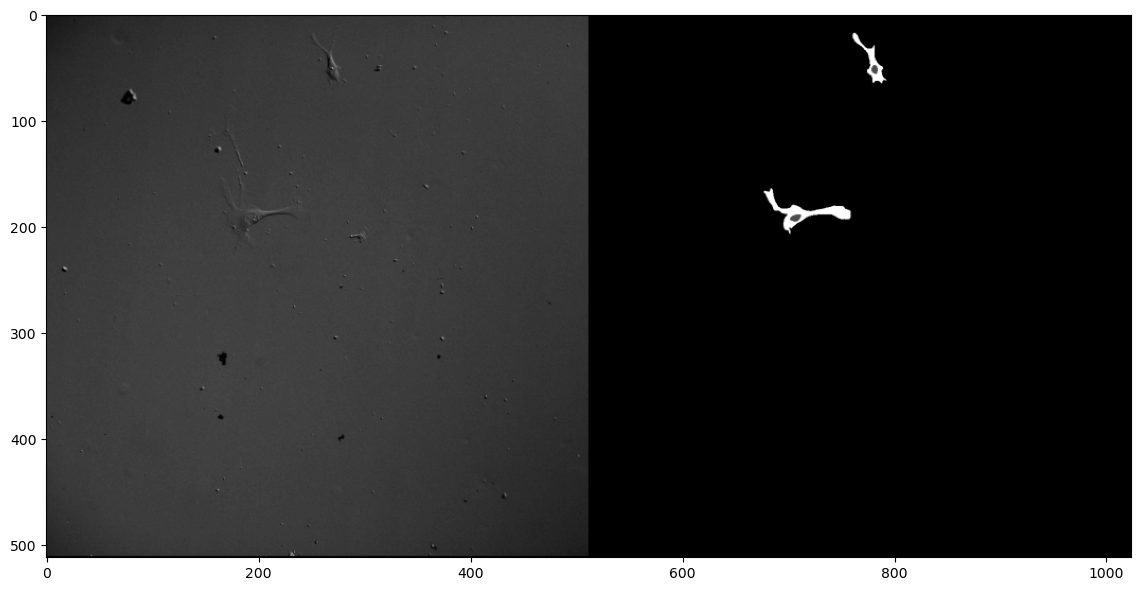

interactive(children=(IntSlider(value=1, description='frame', layout=Layout(height='40px', width='90%'), max=7…

<function __main__.f(frame)>

In [51]:
## Scroll through movie using matplotlib
with capture_output():
  def f(frame):
      print("displaying",frame);
      l.set_data(combineds[frame-1])
      fig.canvas.draw() #use with %matplotlib notebook
      display(fig) #use with %matplotlib inline
      # plt.imshow(img_median, cmap="gray") #This would work
      #plt.show()

  fig = plt.figure(figsize=(14, 8))
  ax_mask = fig.add_subplot(111) 
  l = ax_mask.imshow(combineds[0], cmap="gray")

interact(f, frame=widgets.IntSlider(min=1,max=len(combineds),step=1,value=1,msg_throttle=1,layout=Layout(width='90%', height='40px'))) 


# Get cell features, labeled masks

### Fetch cell and nucleus masks

In [13]:
folder_incell = foldermasks
folder_innuc = foldernucmasks

#get cell_nuc_masks names
masknames=[f for f in os.listdir(folder_incell) if f.endswith('.TIF')]

### Create Cell Metrics (centers and labels), Save data in analysis_output_folder, and transfer to GCP bucket. (~1-2 minutes per movie)

In [14]:
#SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
folder_cellmasks_labeled = analysis_output_folder+'/'+Path(labeled_cellmasks_path).stem
folder_nucmasks_labeled = analysis_output_folder+'/'+Path(labeled_nucmasks_path).stem
if not os.path.exists(folder_cellmasks_labeled):
  os.mkdir(folder_cellmasks_labeled);
if not os.path.exists(folder_nucmasks_labeled):
  os.mkdir(folder_nucmasks_labeled);
try:
  with open(cell_reading_params_path,'rb') as f:
    reading_cells_parameters = pickle.load(f);
except Exception as e:
  raise Exception("Error: missing reading cells parameters, did you make sure to run segmentation quality control first?") from e

basename = reading_cells_parameters['basename'];
frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];

#not necessary to specify columns, but this way 'movie' and 'frame' will be at the beginning of the cells data frame
cellmetrics=pd.DataFrame(columns=['movie','frame'],dtype=int);
metriclist = [];
m = master_bar(movies)
for s in m:
  # print(s,frames[s]);
  for fr in progress_bar(frames[s],parent=m):
      filename = folder_incell+'/'+(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF');
      filenamenuc = folder_innuc+'/'+(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF');
      
      mem = imread(filename);
      mem = ndimage.binary_fill_holes(mem);
      mem[mem != 0] = 1;
      nuc = imread(filenamenuc);
      nuc[nuc != 0] = 1;
      
      #get cell features in a mask and the labeled mask
      cellmetric, labeledcellmask,labelednucmask = getcells(mem,nuc,reading_cells_parameters,True);


      #SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
      imsave(folder_cellmasks_labeled+'/'+(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF') , labeledcellmask,check_contrast=False);
      imsave(folder_nucmasks_labeled+'/'+(basename + "_s" + str(s)+'_t'+str(fr)+'.TIF') , labelednucmask,check_contrast=False);
      if not cellmetric.empty:
        # print("hello");
        #Add columns corresponding to movie and frame
        cellmetric['movie']=s
        cellmetric['frame']=fr
        #adds metricsmaskcells below cells
        metriclist.append(cellmetric)

cellmetrics = pd.concat(metriclist)

/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/nas/lon

In [15]:
cellmetrics.to_csv(analysis_output_folder+'/cell_features.csv')

# Track Cells (Requires Cell Features) - May need to modify

Reads cell_features from folder_output in GCP bucket, writes tracking_parameters and tracks to folder_output in GCP bucket

 can be either "centroid" or "approximate-medoid"

maxdist is the maximum distance in pixels allowed for a cell jump

dfracsize is the maximum fractional change in area allowed

The output (tracks) should be a file in the output folder ending with "tracks.pkl" containing a list of tables (each table is a track)

In [16]:
with open(cell_reading_params_path,'rb') as f:
  reading_cells_parameters = pickle.load(f);

# Cell Tracking Parameters

#which center type (centroid or medoid) to use for tracking
centroidtype = 'approximate-medoid' ###May need to modify
#maximum jump size allowed in pixels
max_tracked_speed =  100 ###May need to modify 
#maximum fractional area change 
dfracsize=0.99 ###May need to modify



## Disappeared Cell Tracking Parameters
#### Filters on how a track whose that has disappeared can snap to a newly appeared cell

#maximum frames the tracker will remember a cell's position when not in frame before it gets deleted
max_track_disappeared_time =  2 ###May need to modify

#minimum length of continuous track required for persistence through disappeared
min_track_persistence_time = 5 ###May need to modify

options = ["Speed (linear)", "Diffusivity (MSD)"]
class SpeedType(Enum): 
  linear = "linear";
  MSD = "MSD";
  def __str__(self): 
    return self.value;

#Speed type - whether to use linear speed or mean squared displacement to filter for the distance a cell can move while disappeared
untracked_speed_type_str = "Diffusivity (MSD)" 
untracked_speed_type = [SpeedType.linear,SpeedType.MSD][options.index(untracked_speed_type_str)];

#If using linear speed: maximum average distance a cell that has disappeared can move per frame while still being snapped back to nearest previous position; that is, cell is accepted if distance(C1,C2) < time*max_untracked_speed
max_untracked_speed = 100 ###May need to modify

#If using MSD: maximum MSD of an cell that has disappeared moving over the course of t frames to be considered the same as a previously tracked cell; that is, cells will be considered the same if distance(C1,C2)^2 < time*max_untracked_diffusivity. First frame's distance will be sqrt(D), then sqrt(2D), then sqrt(3D), etc
max_untracked_diffusivity = 5 ###May need to modify

###IGNORE THE CELL COLLECTION STUFF
### Cell Collection: Whether to have only a specific section of movie where new tracks can be added
#Probably outdated, initial track delay in track qc is probably better, which does the same thing but throughout the movie with after-the-fact information
do_cell_collection = False 
#Cell Collection Time: For how many frames at the begininng of the movie do we still accept new cells
cell_collection_time = 36 
###

trackinging_parameters={
    'centroidtype':centroidtype, 
    'max_tracked_speed':max_tracked_speed, 
    'dfracsize':dfracsize,
    'max_disappeared_time':max_track_disappeared_time,
    'untracked_speed_type':str(untracked_speed_type),
    'do_cell_collection':do_cell_collection,
    'cell_collection_time':cell_collection_time,
    'min_track_persistence_time':min_track_persistence_time};
if untracked_speed_type == SpeedType.linear:
  trackinging_parameters['max_untracked_speed'] = max_untracked_speed;
elif untracked_speed_type == SpeedType.MSD:
  trackinging_parameters['max_untracked_diffusivity'] = max_untracked_diffusivity;


with open(track_params_path, 'wb') as handle:
    pickle.dump(trackinging_parameters, handle)

#This specify the cell metrics tracking is going to use
fields = ['label','movie','frame',centroidtype+'x',centroidtype+'y','area']


#read cell shape features as data frame
sample_cells:pd.DataFrame = pd.read_csv(analysis_output_folder+'/cell_features.csv', usecols=fields)

sample:Dict[int,Dict[int,pd.DataFrame]] = {}; #movie index, tracks
# to_use = [m for m in movies if m not in fails] if 'fails' in locals() else movies;

class Cell:
  def __init__(self,frame:pd.DataFrame):
    self.frame = frame;
    self.min_dist = None;
  
  @staticmethod
  def cell_distance(t0:Cell,t1:Cell)->float:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      out = math.sqrt((t0_f[centroidtype+'x']-t1_f[centroidtype+'x'])**2 + (t0_f[centroidtype+'y']-t1_f[centroidtype+'y'])**2);
      if (t1.min_dist is None or out < t1.min_dist):
        t1.min_dist = out;
      return out;

  def __str__(self):
    return f"Cell <{builtins.id(self)}>:\nframe: \n" + str(self.frame) + ",\nminimum distance:" + str(self.min_dist)

  @staticmethod
  def cells_filter(t0:Cell,t1:Cell,disappeared_time:int,dist:float)->bool:
    t0_f = None;
    t1_f = None;
    good_area = None;
    try:
      t0_f = t0.frame.iloc[0];
      t1_f = t1.frame.iloc[0];
      # raise Exception();  
      good_area:bool = float(t1_f['area']) > (float(t0_f['area'])*(1-dfracsize)) and float(t1_f['area']) < (float(t0_f['area'])*(1+dfracsize));
    except Exception as e:
      print(t0,t1);
      print(t0_f,t1_f);
      print(t0_f['area'],t1_f['area']);
      print(type(t0_f['area']),type(t1_f['area']));
      print(good_area);
      raise e;

    if disappeared_time == 0:
        result = dist < max_tracked_speed;
    else:
        if untracked_speed_type == SpeedType.linear:
          result = dist < max_untracked_speed*disappeared_time;
        elif untracked_speed_type == SpeedType.MSD:
          result = dist**2 < max_untracked_diffusivity*disappeared_time;
        else:
          raise Exception();

    if not(good_area) and result:
        result = False;

    return result


frames = reading_cells_parameters['frames'];
movies = reading_cells_parameters['movies'];
m = master_bar(movies);
for s in m:
    print(f"tracking movie #{s}");
    tracklists:Dict[int,list[pd.DataFrame]] = {} #objectid, frames
    tracker = CentroidTracker[Cell](
        Cell.cell_distance,
        frame_filter=Cell.cells_filter,
        maxDisappearedFrames=max_track_disappeared_time,
        minPersistenceFrames=min_track_persistence_time);
    for fr in progress_bar(frames[s],parent=m):

        #get cells in current frame
        maskcells:pd.DataFrame = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]

        cells = [Cell(maskcells.iloc[[i]]) for i in range(len(maskcells))];
        objects = tracker.update(cells,allow_new = (fr < cell_collection_time or not(do_cell_collection)));        
        pass;
        for id,cell in objects.items():
            frame = cell.frame.copy();
            if id in tracklists:
              if tracker.disappeared[id] > 0:
                frame['label'] = -1; #disconnect repeated frame from mask label
                frame['frame'] = fr;
              tracklists[id].append(frame);
            else:
              tracklists[id] = [frame];
    
    #concat all tracks together
    tracks:Dict[int,pd.DataFrame] = {tid:pd.concat(tracklists[tid],ignore_index=True) for tid in tracklists}
    sample[s] = tracks

with open(raw_tracks_path, 'wb') as handle:
    pickle.dump(sample, handle)


print("Tracking complete");


tracking movie #0
tracking movie #1
tracking movie #2
tracking movie #3
tracking movie #4
tracking movie #5
tracking movie #6
tracking movie #7
tracking movie #8
tracking movie #9
tracking movie #10
tracking movie #11
tracking movie #12
tracking movie #13
tracking movie #14
tracking movie #15
tracking movie #16
tracking movie #17
tracking movie #18
tracking movie #19
tracking movie #20
tracking movie #21
tracking movie #22
tracking movie #23
tracking movie #24
tracking movie #25
tracking movie #26
tracking movie #27
tracking movie #28
tracking movie #29
tracking movie #30
tracking movie #31
tracking movie #32
tracking movie #33
tracking movie #34
tracking movie #35
Tracking complete


# Tracking Quality Control - Visualization & Filtering

### Get analysis folder data from directory where analysis is saved. Read tracks and cell shape features (centers will be used for display)

In [17]:
sample_cells_metrics = pd.read_csv(analysis_output_folder+'/cell_features.csv')
reading_cells_parameters = None;
with open(cell_reading_params_path,'rb') as handle:
  reading_cells_parameters = pickle.load(handle,encoding='latin1');

# print(tracks);

### Perform QC operations, push parameters to GCP

keep: {movie:[track1,track2,etc]} - note that any unspecified movies will be left with all tracks

example:
keep={4:[1],6:[1],8:[7],11:[1,2],14:[9],17:[4],18:[1],19:[1],23:[3],24:[1,2,6],28:[1]}

trim: {(movie,track):(firstframe_keep,lastframe_keep)}; if track is -1, will trim the whole movie to that trim

example:
trim={(4,1):(1,6),(17,4):(1,10),(25,1):(1,31),(26,1):(1,6)}

removemov: [movie]

example:
removemov=[1,5,10,12,22,27,30]

exclude: [movie,track]

exclude=[(3,7),(13,2)]

Here "movie" is the number assigned by the microscope, in filename [basename]_s[movie]_t[frame].tif

In [19]:
#####THIS NEEDS TO BE MODIFIED!!!! 
####AT THE BEGINNING OF EACH NEW DATASET BEING ANALYZED ALL THE OLD INPUTS FOR THE VARIABLES "keep", "trim", "removemov", AND "exclude" NEED TO BE EMPTY AND AS YOU PERFORM QUALITY CONTROL FOR THIS DATASET MODIFY AS NECESSARY

#INPUT QC OPERATIONS 
#the minimum track length to include (frames)
minTrackLength=10 #MAY NEED TO MODIFY

#the minimum displacement over the length of the track (pixels)
minTrackDisplacement=None 

#how long to wait after a track's appearance before including it (buffer period for cell division/collisions, segmentation issues, etc)
initialTrackDelay = 0 



#dict of {movie:[track1,track2,etc]} specific tracks to keep from particular movies; *only* the tracks specified in the movie will be kept
#when empty should look like: keep={}
keep={2:[1,71,73], 4:[3,4,7,53], 6:[2,8],7:[27,30],9:[1,2,3,53],11:[8,9],17:[10,14],18:[24,2,25,78,107,109,96,15],19:[189,195],22:[19,57],23:[0,1,104],24:[0,1,6,19,24,53,46],25:[0,2,14,46,71],27:[2,30],29:[0,2,5,55],30:[56,59],34:[0,15]}

#dict of {(movie,track):(startframe,endframe)} sets the frame bounds of specific tracks in the sample
#when empty should look like: trim={}
trim={}  

#list of specific movies to exclude (overrides keep)
#when empty should look like: removemov=[]
removemov=[8,16,20,31] 

#list of (movie,track): specific tracks to exclude
#when empty should look like: exclude=[]
exclude=[] 

in_tracks = {}
with open(raw_tracks_path, 'rb') as handle:
  in_tracks = pickle.load(handle, encoding='latin1')

#apply QC operations
sampTrStatus, sample = apply_qc(in_tracks,keep,trim,removemov,exclude,minTrackLength=minTrackLength,minTrackDisplacement=minTrackDisplacement,initialTrackDelay=initialTrackDelay);
##SampTrStatus: dict of {movie#:statuses}, where statuses is a dict of {trackid:status}; in this case, status = 0 means bad track, status = 1 means good track

trackingChanged = True;

qc_output= {'tracks_status':sampTrStatus, 'qc_tracks':sample, 
            'minTrackLength':minTrackLength,
            'minTrackDisplacement':minTrackDisplacement,
            'initialTrackDelay': initialTrackDelay,
            'keep':keep, 'trim':trim, 'removemov':removemov, 
            'exclude':exclude}

with open(qc_params_path, 'wb') as handle:
    pickle.dump(qc_output, handle)

tracksreg={}
for imov in sample:
  tracksreg[imov] = {}
  for itr in sample[imov]:
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      tracksreg[imov][itr] = (sample[imov][itr])

with open(qc_tracks_path, 'wb') as f:
  pickle.dump(tracksreg,f)


removing track 0 from movie 0: track length too short
removing track 1 from movie 0: track length too short
removing track 2 from movie 0: track length too short
removing track 3 from movie 0: track length too short
removing track 4 from movie 0: track length too short
removing track 5 from movie 0: track length too short
removing track 6 from movie 0: track length too short
removing track 7 from movie 0: track length too short
removing track 8 from movie 0: track length too short
removing track 9 from movie 0: track length too short
removing track 10 from movie 0: track length too short
removing track 11 from movie 0: track length too short
removing track 12 from movie 0: track length too short
removing track 13 from movie 0: track length too short
removing track 14 from movie 0: track length too short
removing track 15 from movie 0: track length too short
removing track 16 from movie 0: track length too short
removing track 17 from movie 0: track length too short
removing track 18 fr

## Visualize Tracks, Perform track QC

**Tracking Quality Control Instructions:**

Select which movie to view by changing the movie field in the cell below and re-running. If you see a track you want to remove or trim, you can edit the options in the cell above and re-run it to apply those edits. If you want to change the tracking parameters themselves, you can change the parameters of the final cell in the previous section (Get Cell Features (table), labeled masks, and track) and re-run it to re-do tracking, then run the previous and following cells.


In [20]:
## Input Tracking Display Parameters
#Nucleus intensity for combined image (between 0 and 1)
nucfrac=0.7 

#Frame downsample rate (how often a frame is shown); increase this number for a faster processing time but less fine time-control
frspace=1 

#Mask intensity of cells segmented but not tracked (between 0 and 1);
untracked_intensity = 0.2 

#Mask intensity of cells segmented and tracked but excluded from tracking by quality control (will be in red)
excluded_intensity = 0.3 

#how much to resize the image by (the more downscaled, the faster the playing but the less the resolution)
downfrac = 0.5 

#how large to plot the cell centers (pixels)
centersize = 2 

#how large to draw the track id# (scaling from base size)
textsize =  0.5

### Track Display

#how thick to draw the cell tracks
trackwidth = 1

trackingChanged = True;


images = {} if 'images' not in globals() or trackingChanged else images; #dict of movie: {True:[with_names],False:[without_names]}
masks = {} if 'masks' not in globals() or trackingChanged else masks; #dict of movie {True:[with_centers],False:[without_centers]}
tracks_images = {} if 'tracks' not in globals() or trackingChanged else tracks_images; #dict of movie:list[tracks]

process_ready = False

In [21]:
try:
    from google.colab.patches import cv2_imshow
except:
    cv2_imshow = cv2.imshow
##Prepare tracking display function (Required for computing display frames)
track_params = {};
with open(track_params_path,'rb') as handle:
  track_params = pickle.load(handle,encoding='latin1');
centertype = track_params['centroidtype'];

textfont = cv2.FONT_HERSHEY_SIMPLEX


imagebasename = reading_cells_parameters['basename'];
movies = reading_cells_parameters['movies'];

def get_frame(images,masks,tracks_images,frame,showCenters=False,showNames=False,showTime=False,tracks_display="Neither"):
    image = images[showNames][frame].copy();
    mask = masks[showCenters][frame].copy();
    if tracks_display != "Neither":
      tracks = tracks_images[frame];
      alpha = np.where((tracks != 0).any(axis=2),1,0); #pixels set to 1 where there is at least one nonzero element of the rgb (not black)
      if tracks_display in ["Image side","Both"]:
        overlay_image_alpha(image,tracks,0,0,alpha);

      if tracks_display in ["Mask side","Both"]:
        overlay_image_alpha(mask,tracks,0,0,alpha);


    combined = np.hstack((mask,image))
    combined = rescale_intensity(combined,out_range=np.uint8).astype(np.uint8);
    if showTime:
      combined = cv2.putText(combined,str(frame),(0,combined.shape[0]),textfont,textsize,(255,255,255),1);
    return combined

def f(frame,showCenters=False,showNames=False,tracks_display="Neither"):
  c = get_frame(images,masks,tracks_images,frame,showCenters=showCenters,showNames=showNames);
  l.set_data(c);
  fig.canvas.draw() #use with %matplotlib notebook
  display(fig) #use with %matplotlib inline


def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2,:]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o,:]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

def process_movie(movie:int,frames:list,parentbar=None):
      if movie not in movies:
        raise Exception(f"movie selection {movie} not in experimental list of movies {movies}");
      if not process_ready:
        raise Exception("Attempted to process movies with out of date parameters; run the \"Prepare Tracking Function\" Cell")
      movie_tracks = sample[movie];
      print(f"processing movie #{movie}");
    
      
      #random color per id, will be consistent for that id within the movie
      centerColors = DefaultDict(lambda: (random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)));
      grey = (50,50,50);
      [centerColors.update([(id,grey)]) for id,status in sampTrStatus[movie].items() if not status];
      
      acc_tracks_image = None;
      prev_track_pos = None;

      timage = {True:{},False:{}}
      tmask = {True:{},False:{}}
      ttrack_images = {}

      for i in progress_bar(frames,parent=(parentbar or None)):
          filename_mask = imagebasename + "_s" + str(movie)+"_t"+str(i)+".TIF";

          maskmem = imread(foldermasks+'/'+filename_mask);
          masknuc = imread(foldernucmasks+'/'+filename_mask);
          
          #read image
          filename_img = imagebasename + "_s" + str(movie)+"_t"+str(i)+".tif";
          imageorig = color.rgb2gray(imread(folderimages+'/'+filename_img))

          #rescale image intensity
          imageorig = rescale_intensity(imageorig);
          image=resize(imageorig, (maskmem.shape[0] * downfrac , maskmem.shape[1] * downfrac),  anti_aliasing=True); #this order matters so that the data types work out
          image = rescale_intensity(image,out_range=np.uint8).astype(np.uint8);
          image = np.stack((image,image,image),axis=2); #make color image
          
          
          
          trackedLabels = [];
          rejectedLabels = [];
          centers = {};
          for tid,data in movie_tracks.items():
            fDat = data[data['frame']==i];
            if not fDat.empty:
              trackedLabels.append(fDat)
              if not sampTrStatus[movie][tid]:
                rejectedLabels.append(fDat);
              centers[tid] = fDat[[centertype+'x',centertype+'y']].reset_index();
          
          
          #get the label of every tracked mask in this frame
          trackedLabels = pd.concat(trackedLabels)['label'] if len(trackedLabels) > 0 else [];
          rejectedLabels = pd.concat(rejectedLabels)['label'] if len(rejectedLabels) > 0 else []


          #create bitmasks of untracked and rejected cells
          cellmask = (maskmem != 0);
          untracked = np.isin(maskmem,trackedLabels,invert=True) & cellmask
          rejected = np.isin(maskmem,rejectedLabels);
          
          #draw tracks
          if acc_tracks_image is None:
            acc_tracks_image = np.zeros(np.array(image.shape),dtype=np.uint8);
            prev_track_pos = centers;
          else:
            for id in centers:
              if id in prev_track_pos:
                prev = prev_track_pos[id];
                prev = (int(prev[centertype+'x'][0]*downfrac),int(prev[centertype+'y'][0]*downfrac));

                pos = centers[id];
                pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));

                acc_tracks_image = cv2.line(acc_tracks_image,prev,pos,centerColors[id],trackwidth);
            prev_track_pos = centers;

          ttrack_images[i] = acc_tracks_image.copy();        

          #unlabel for visualization
          maskmem[maskmem>=1] = 1

          #combine membrane and nucleus masks
          maskcomb = (maskmem - nucfrac*masknuc)
          maskcomb[maskcomb<0]=0; #floating point stuff, this is so stupid

          #apply untracked and excluded intensities
          maskcomb[untracked] *= untracked_intensity;
          maskcomb[rejected] *= excluded_intensity

          #rescale to full intensity, make int8 again
          maskcomb = rescale_intensity(maskcomb,out_range=np.uint8).astype(np.uint8);

          #color rejected cells red
          qcomb = (maskcomb//4).astype(maskcomb.dtype);
          halfmask = np.where(rejected,qcomb,maskcomb);
          
          #turn into rgb image
          maskcomb = np.stack((maskcomb,halfmask,halfmask),axis=2);

          #downscale
          maskcomb=resize(maskcomb,(int(maskcomb.shape[0]*downfrac), int(maskcomb.shape[1]*downfrac)),preserve_range=True).astype(np.uint8);

          #save unannotated frames
          tmask[False][i] = maskcomb.copy();
          timage[False][i] = image.copy();

          #annotate with centers and names
          for id,pos in centers.items():
            pos = (int(pos[centertype+'x'][0]*downfrac),int(pos[centertype+'y'][0]*downfrac));
            maskcomb = cv2.circle(maskcomb,pos,2,centerColors[id],-1);
            image = cv2.putText(image,str(id),pos,textfont,textsize,centerColors[id],1);

          #save annotated frames
          tmask[True][i] = maskcomb;
          timage[True][i] = image;
      return timage,tmask,ttrack_images

process_ready = True

### MODIFY THIS CELL

In [22]:
### Compute Tracking Display Frames
#Get combined images & masks for visualization, draw mask centers and labeled names

#Which movie to load
movie_selection=35 #MODIFY THIS VALUE TO CHANGE WHICH MOVIE TO VIEW

#if you want to process the other movies while loading the selection
process_all = False 

#Force reprocessing of selected movie (select if running this cell with new data/parameters says "previously prepared)
force_reprocess = False 

to_process = master_bar(movies) if process_all else [movie_selection];


for movie in to_process:
  frames = reading_cells_parameters['frames'][movie][::frspace];

  movie_tracked = True;
  if movie not in images or len(images[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in masks or len(masks[movie][True]) != len(frames):
    movie_tracked = False;
  if movie not in tracks_images or len(tracks_images) != len(frames):
    movie_tracked = False;

  if not movie_tracked or (movie == movie_selection and force_reprocess):
    images[movie],masks[movie],tracks_images[movie] = process_movie(movie,frames,to_process if process_all else None);
trackingChanged = False;

processing movie #35


In [23]:
## View Tracking Output - Mediapy
### (Requires computing display frames for selected movie)
### Mediapy results in a much cleaner video experience than matlab, but can't be changed dynamically
#Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
framerate =  1
### Annotation Parameters:
centers = True 
names = True 
frameNumber = True 
#whether and where to draw the tracks of each cell on the image frames
display_tracks_side = "Mask side" 



frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
print(frlist)
try:
  media.show_video(starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
except NameError as e:
  raise Exception("Unable to load movie - did you set up the frame function?") from e;
except KeyError as k:
  raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;


[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [156], [157], [158], [

In [34]:
# ## Save Video Output (Mediapy)
# ### (Requires computing display frames for selected movie)
# Framerate: speed of movie playing in frames per second (not limited by processing time, can go as fast as you want);
# framerate = 3
# ### Annotation Parameters:
# centers = True 
# names = True 
# frameNumber = True 
# whether and where to draw the tracks of each cell on the image frames
# display_tracks_side = "Mask side" # ["Neither", "Mask side", "Image side", "Both"]

# GCP output filename (to automatically name the path based on movie#, put "{movie}" in the name)
# gcp_out_path = "trackqc_mov{movie}.mp4" 
# gcp_out_path:Path = Path(format_path(gcp_out_path,movie=movie_selection,collection=track_params['do_cell_collection']));

# ##### Treat the above path as relative to the experiment's analysis output folder?
# in_analysis = True 

# local_path = local_analysis_output_folder / gcp_out_path if in_analysis else temp_folder / Path(gcp_out_path).name
# gcp_out_path = gcp_analysis_output_folder / gcp_out_path if in_analysis else Path(gcp_out_path);
# frlist = [[f] for f in reading_cells_parameters['frames'][movie][::frspace]];
# try:
#   media.write_video(local_path,starmap(partial(get_frame,images[movie_selection],masks[movie_selection],tracks_images[movie_selection],showCenters=centers,showNames=names,showTime=frameNumber,tracks_display=display_tracks_side),progress_bar(frlist)),fps=framerate);
# except NameError as e:
#   raise Exception("Unable to load movie - did you set up the frame function?") from e;
# except KeyError as k:
#   raise Exception("Unable to load entire movie - run the parameters and computation cells to ensure full movie complete") from k;

# !gsutil -m cp "{gs_str(local_path)}" "{gs_str(gcp_out_path)}"


# Save masks for tracks in tiff stacks

In [13]:
folder_cellmasks_labeled = analysis_output_folder+'/'+Path(labeled_cellmasks_path).stem
folder_nucmasks_labeled = analysis_output_folder+'/'+Path(labeled_nucmasks_path).stem

In [14]:
#function to read a mask corresponding to a given movie (implicit parameter), and frame (explicit parameter iframe)
#get_mask = lambda iframe: imread( masks_folder/basename+'_s'+str(int(movie))+'_t'+str(int(frame[iframe]))+'.TIF')
def get_mask(iframe):
  filename = basename+'_s'+str(int(movie))+'_t'+str(int(frame[iframe]))+'.TIF'
  return imread(folder_cellmasks_labeled+'/'+filename)

#function that returns the mask of a cell centered. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later). 
def get_centered_cell(iframe):
  mask=get_mask(iframe)
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1
  props = measure.regionprops(mask)
  #center image
  centroid=props[0].centroid
  N=mask.shape
  centered=mask[np.ix_((np.arange(N[0]) + int(centroid[0]) - int(N[0]/2)) % N[0] , (np.arange(N[1]) + int(centroid[1]) - int(N[1]/2)) % N[1])]
  return centered

#function that returns the mask of a cell. It takes the cell label in the mask, and the movie
#as implicit parameters determined by the track information (as used later).
def get_cell(iframe):
  mask=get_mask(iframe)  
  #erase all objects with different label as cell
  mask[mask != label[iframe] ] =0
  #set cell positions as 1
  mask[mask > 0 ] = 1

  return mask

rotation_matrix = lambda angle: np.asarray([[np.cos(angle) , -np.sin(angle)],[np.sin(angle), np.cos(angle)]] )


def skew_from_hist(hist):
  value = np.asarray(range(len(hist)))
  mean = np.sum(hist*value)/np.sum(hist)
  m2 = np.sum(hist*(value-mean)**2)/np.sum(hist)
  m3 = np.sum(hist*(value-mean)**3)/np.sum(hist)
  return  m3/m2**(3/2) 


In [84]:
masks_folder = foldermasks

#read pickled tracks
#unpickle tracks  
with open(qc_tracks_path, 'rb') as handle:
  tracks_noshape = pickle.load(handle, encoding='latin1') 

#create folder to store masks from tracks
if not os.path.exists(analysis_output_folder+'/tracks_masks'):
  os.mkdir(analysis_output_folder+'/tracks_masks');
#!mkdir temp_folder/tracks_masks


###Loop to add features to each timepoint of all the tracks
#Add morphological and morphodynamical features to each timepoint (frame) in the tracks

tracks = copy.copy(tracks_noshape)

for movie in tracks:
  for itrack in tracks[movie]:
    tracklength = len(tracks[movie][itrack])
    frame = list(tracks[movie][itrack]['frame'])
    label = list(tracks[movie][itrack]['label'])
    masks=os.listdir(masks_folder)
    #implicit argument to read cells
    basename=re.findall(r"(.+)_s",masks[0])[0] 

    track_masks=[]


    #GET SCIKIT-IMAGE CELL METRICS AND SAVE CELL MASK
    for iframe in range(tracklength):
      cell = get_cell(iframe) 

      #store cell mask
      track_masks.append(cell)

    #SAVE TRACK MASKS AS TIFF STACKS
    track_masks = np.asarray(track_masks)
    savepath = "tracks_masks/" + experiment + "_movie" + str(movie) + "_track"+ str(itrack) + '.TIF'
    imsave(analysis_output_folder+'/'+savepath , track_masks, check_contrast=False)

# Shape2tracks - tracks with shape info

### MODIFY THIS CELL

In [15]:
#label of substrate or region on gel where experiment was taken

region = 'stiff_gel' #MODIFY THIS VARIABLE WITH DESCRIPTION OF SUBSTRATE OF DATA (CURRENTLY 'glass', 'stiff_gel', OR 'soft_gel')

In [16]:
masks_folder = foldermasks

#read pickled tracks
#unpickle tracks  
with open(qc_tracks_path, 'rb') as handle:
  tracks_noshape = pickle.load(handle, encoding='latin1') 


###Loop to add features to each timepoint of all the tracks
#Add morphological and morphodynamical features to each timepoint (frame) in the tracks

tracks = copy.copy(tracks_noshape)

for movie in tracks:
  for itrack in tracks[movie]:
    tracklength = len(tracks[movie][itrack])
    #store experiment and id_track, to retrieve track_masks from track
    tracks[movie][itrack]["experiment"]=experiment
    tracks[movie][itrack]["region"]=region
    tracks[movie][itrack]["track_id"]=itrack
    #read data to retrieve corresponding labeled mask cell
    #movie = tracks[itrack]['movie'].iloc[0]
    frame = list(tracks[movie][itrack]['frame'])
    label = list(tracks[movie][itrack]['label'])
    masks=os.listdir(masks_folder)
    #implicit argument to read cells
    basename=re.findall(r"(.+)_s",masks[0])[0] 

    #get polarization angle, skew, protrusion and retraction angle,norm area, radii 

    median_centroidy = []
    median_centroidx = []
    protrusion_angles=[]
    mean_protrusion_angles=[]
    protrusion_norm_radii =[]
    protrusion_norm_areas=[]
    retraction_angles=[]
    mean_retraction_angles=[]
    retraction_norm_areas=[]
    retraction_norm_radii=[]
    mean_retraction_norm_radii=[]
    mean_protrusion_norm_radii =[]

    cell_angles = []
    cell_skews = []

    #select scikit-image shape metrics
    shape_metrics = ['area','convex_area','eccentricity','orientation','perimeter','equivalent_diameter','solidity','extent','major_axis_length','minor_axis_length','centroid']

    track_shape_metrics = pd.DataFrame()

    #GET SCIKIT-IMAGE CELL METRICS AND SAVE CELL MASK
    for iframe in range(tracklength):
      cell = get_cell(iframe) 
      if np.any(cell) == False:
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        row = np.empty(len(shape_metrics)+1)
        row[:] = np.nan
        cell_shape_metrics = cell_shape_metrics.append(pd.Series(row, index=cell_shape_metrics.columns),ignore_index=True)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        #get median calculated centroid
        celly = np.array(np.nan)
        cellx = np.array(np.nan)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )
      else:
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        #get median calculated centroid
        celly,cellx = np.where(cell)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )



    for iframe in range(tracklength-1):

      #GET CELL POLARIZATION ANGLE 
      cell = get_cell(iframe)
      if np.any(cell) == False:
        cell_angles.append( np.nan )
        cell_skews.append(np.nan)
      else:
        cell_centered = get_centered_cell(iframe)
        props = regionprops(cell_centered)
        #major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
        angle_y = props[0].orientation
        #rotate cell so that major axis is aligned with the y axis
        cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
        #project cell on the x (1) axis
        proj_x = np.sum(cell_y,1)      
        #get cell polarization vector in a regular coordinate system
        #skew sign corresponds to the tail of the distribution, cell polarization is  
        #defined here as -skew. Because image y-axis is inverted, in a regular coordinate
        #system, cell polarization vector is defined as -(-skew) = skew:
        skew_cell = skew_from_hist(proj_x)
        celly_polarization = [0 , skew_cell ]      
        #rotate back
        polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
        cell_angles.append( np.arctan2(polarization[1],polarization[0]) )
        cell_skews.append(abs(skew_cell)) 


      #PROTRUSION AND RETRACTION VECTORS : angle, norm_areas, radii (calculated with medians)
      if np.any(cell) == False or np.any(get_cell(iframe+1)) == False:
        protrusion_angles.append( np.nan )
        protrusion_norm_areas.append(np.nan)
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( np.nan )
        retraction_angles.append(np.nan)
        retraction_norm_areas.append( np.nan )
        retraction_norm_radii.append( np.nan )
        mean_protrusion_angles.append(np.nan)
        mean_retraction_angles.append(np.nan )
        mean_protrusion_norm_radii.append( np.nan )
        mean_retraction_norm_radii.append( np.nan )

        med_centroids = pd.DataFrame({'median_centroidx':[np.nan], 'median_centroidy':[np.nan]})

      else:
        difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
        #get centroids of cell(iframe), protrusion and retraction
        y,x =np.where(get_centered_cell(iframe))
        centroidy, centroidx = np.median(y), np.median(x)
        yp,xp = np.where(difference==1)
        protrusion_y, protrusion_x  = np.median(yp) , np.median(xp)
        yr,xr = np.where(difference==-1)
        retraction_y, retraction_x  = np.median(yr) , np.median(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        protrusion_angles.append( np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) )
        protrusion_norm_areas.append(len(yp)/ len(y))
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( ((protrusion_x-centroidx)**2+(protrusion_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        retraction_angles.append(np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  )
        retraction_norm_areas.append( len(yr)/len(y) )
        retraction_norm_radii.append( ((retraction_x-centroidx)**2+(retraction_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        #PROTRUSION AND RETRACTION angles, radii, calculated with means
        #get centroids of cell(iframe), protrusion and retraction
        mean_centroidy, mean_centroidx = np.mean(y), np.mean(x)
        mean_protrusion_y, mean_protrusion_x  = np.mean(yp) , np.mean(xp)
        mean_retraction_y, mean_retraction_x  = np.mean(yr) , np.mean(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        mean_protrusion_angles.append(np.arctan2( -(mean_protrusion_y - mean_centroidy), mean_protrusion_x - mean_centroidx) )
        mean_retraction_angles.append(np.arctan2( -(mean_retraction_y - mean_centroidy), mean_retraction_x - mean_centroidx) )
        mean_protrusion_norm_radii.append( ((mean_protrusion_x-mean_centroidx)**2+(mean_protrusion_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        mean_retraction_norm_radii.append( ((mean_retraction_x-mean_centroidx)**2+(mean_retraction_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        med_centroids = pd.DataFrame({'median_centroidx':median_centroidx, 'median_centroidy':median_centroidy})

    shape_features= pd.DataFrame({'polarity_angle':cell_angles, 'abs-skew':cell_skews, 
                              'protr_angle':protrusion_angles, 'mean_protr_angle':mean_protrusion_angles, 'protr_norm_area':protrusion_norm_areas, 
                          'retr_angle': retraction_angles, 'mean_retr_angle': mean_retraction_angles, 'retr_norm_area': retraction_norm_areas,
                          'protr_norm_radii':protrusion_norm_radii, 'mean_protr_norm_radii':mean_protrusion_norm_radii,
                          'retr_norm_radii':retraction_norm_radii, 'mean_retr_norm_radii':mean_retraction_norm_radii, })

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), track_shape_metrics.reset_index(drop=True)], axis = 1 )

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), med_centroids.reset_index(drop=True)], axis = 1 )

    tracks[movie][itrack] = pd.concat([tracks[movie][itrack].reset_index(drop=True), shape_features.reset_index(drop=True)], axis = 1 )

###Save updated tracks

with open(analysis_output_folder+'/tracks_shape.pkl', 'wb') as handle:
    pickle.dump(tracks, handle, protocol=2)

/tmp/ipykernel_2447629/2474407582.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
/tmp/ipykernel_2447629/2474407582.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cell_shape_metrics = cell_shape_metrics.append(pd.Series(row, index=cell_shape_metrics.columns),ignore_index=True)
/tmp/ipykernel_2447629/2474407582.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
/nas/longleaf/home/emae/anaconda3/envs/cell_tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axi